<a href="https://colab.research.google.com/github/chayapan/thesis/blob/workspace/StockPrediction_ADVANC_neuralNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Prediction 



In [196]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [197]:
dataset = pd.read_csv("https://github.com/chayapan/thesis/raw/master/dataset/historical/ADVANC.csv")
dataset = dataset.set_index('Date')

# DataFrame.iloc[:, n:m] select feature columns from the data frame.
# 0:1 -> High
# 1:2 -> Low
# 2:3 -> Open
# 3:4 -> Close
# 4:5 -> Volume
# 5:6 -> Adj Close

# train_from, train_to, test_from, test_to, feature_cols_from, feature_cols_to, input_window_size=50
train_from='2015-01-01'
train_to='2015-10-01'
test_from='2015-10-02'
test_to='2015-12-32'
feature_cols_from=3  # Closing price only 
feature_cols_to=4
input_window_size=30
forecast_horizon=10
hidden_layers=4

dataset_train = dataset[train_from:train_to]

training_set_df = dataset_train.iloc[:, feature_cols_from:feature_cols_to]
training_set = training_set_df.values # np.array

dataset_test = dataset[test_from:test_to]
test_set = dataset_test.iloc[:, feature_cols_from:feature_cols_to].values

# training_set and test_set in np.array format prepared.

# Feature scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0,1))
training_set_scaled = sc.fit_transform(training_set)

# Creating a data structure with 60 timesteps and 1 output

X_train = []
y_train = []
for i in range(input_window_size, len(training_set)-forecast_horizon): # CHECK this
    # Check labeled forecast value don't exceed time horizon in observation set.
    X_train.append(training_set_scaled[i-input_window_size:i, 0])  # This is 0 - input window size
    y_train.append(training_set_scaled[i+forecast_horizon-1, 0])       # This forecast horizon. Subtract 1 corrects for present time

X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)) # This is important!!


In [ ]:
# Check
# dataset.head()

# Check
# X_train, y_train

In [ ]:
# What does this look like?

# Depth (rows) and Each row size
len(X_train), len(X_train[0])      # Size of each row is the input window size. Size of array X_train is total number of examples.

(143, 30)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Dropout

# Initialize the RNN
regressor = Sequential()

# Adding the first LSTM layer and Dropout regularization
# 41:00 The units is dimensionality of the output space. 
# In this case we have 60 coming in and 50 going out. (In the example. So we want unit to not exceed input window size (example sequence length))

n_units = 4
if input_window_size==50:
    n_units = 40
assert(n_units<input_window_size) # This need checking.

regressor.add(LSTM(units=n_units, return_sequences=True, input_shape=(X_train.shape[1], 1)))
regressor.add(Dropout(0.2))


# Depth of network
if hidden_layers==4:  # Add two more layers here.
    # Adding a second LSTM layer and some Dropout regularization
    # Dropout helps forget some information
    regressor.add(LSTM(units=n_units, return_sequences=True))
    regressor.add(Dropout(0.2))
    # Adding a third LSTM layer and some Dropout regularization
    # Dropout helps forget some information
    regressor.add(LSTM(units=n_units, return_sequences=True))
    regressor.add(Dropout(0.2))

# Last LSTM layer
# Adding a fourth LSTM layer and some Dropout regularization
# Dropout helps forget some information

regressor.add(LSTM(units=50)) # Last of RNN layer dont return sequences
regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units=1))

In [ ]:
regressor.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
history = regressor.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
5/5 [==============================] - 6s 45ms/step - loss: 0.2703
Epoch 2/100
5/5 [==============================] - 0s 41ms/step - loss: 0.1627
Epoch 3/100
5/5 [==============================] - 0s 40ms/step - loss: 0.0950
Epoch 4/100
5/5 [==============================] - 0s 41ms/step - loss: 0.0645
Epoch 5/100
5/5 [==============================] - 0s 41ms/step - loss: 0.0583
Epoch 6/100
5/5 [==============================] - 0s 43ms/step - loss: 0.0435
Epoch 7/100
5/5 [==============================] - 0s 42ms/step - loss: 0.0566
Epoch 8/100
5/5 [==============================] - 0s 42ms/step - loss: 0.0444
Epoch 9/100
5/5 [==============================] - 0s 44ms/step - loss: 0.0494
Epoch 10/100
5/5 [==============================] - 0s 43ms/step - loss: 0.0459
Epoch 11/100
5/5 [==============================] - 0s 42ms/step - loss: 0.0451
Epoch 12/100
5/5 [==============================] - 0s 41ms/step - loss: 0.0429
Epoch 13/100
5/5 [==============================]

In [ ]:
# 
# regressor.save('50-50-50-50_h40_w50_f1d')

In [ ]:
# Make prediction


real_stock_price = dataset_test.iloc[:, feature_cols_from:feature_cols_to].values

In [ ]:
dataset_total = pd.concat((dataset_train['Close'], dataset_test['Close']), axis=0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - input_window_size:].values

In [ ]:
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

In [ ]:
X_test = []
for i in range(input_window_size, len(dataset_test) + input_window_size):
    X_test.append(inputs[i-input_window_size:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def mean_absolute_percentage_error(y_true, y_pred): 
    """ From https://gist.github.com/amanahuja/6315882
    Use like any other metric
    >>> y_true = [3, -0.5, 2, 7]; y_pred = [2.5, -0.3, 2, 8]
    >>> mean_absolute_percentage_error(y_true, y_pred)
    Out[]: 24.791666666666668
    """
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


MAE = mean_absolute_error(real_stock_price, predicted_stock_price)
MSE = mean_squared_error(real_stock_price, predicted_stock_price)
MAPE = mean_absolute_percentage_error(real_stock_price, predicted_stock_price)

print("""MAE: %0.4f  MSE: %0.4f MAPE: %0.4f""" % (MAE, MSE, MAPE)) 

MAE: 32.7306  MSE: 1909.5422 MAPE: 17.8754


In [ ]:
input_window_size

30

In [ ]:
features_used = str(list(dataset.columns[feature_cols_from:feature_cols_to].values))
acc_metrics = """MAE: %0.4f  MSE: %0.4f MAPE: %0.4f""" % (MAE, MSE, MAPE)

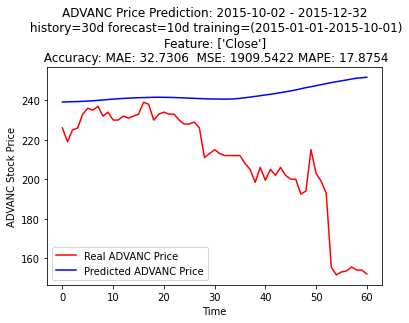

In [ ]:
plt.plot(real_stock_price, color = 'red', label='Real ADVANC Price')
plt.plot(predicted_stock_price, color='blue',label='Predicted ADVANC Price')
plt.title('ADVANC Price Prediction: %s - %s\n history=%sd forecast=%sd training=(%s-%s)\nFeature: %s\n Accuracy: %s' % 
                    (test_from, test_to, input_window_size, forecast_horizon, train_from, train_to, features_used, acc_metrics))
plt.xlabel('Time')
plt.ylabel('ADVANC Stock Price')
plt.legend()
plt.show()

## Autoencoder

In [198]:
# Volatility is High-Low/Close

dataset['Return'] = (dataset['Close'].shift() - dataset['Close']) / dataset['Close']
dataset['Volatility'] = (dataset['High'] - dataset['Low']) / dataset['Close']


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff3c7fbdad0>]],
      dtype=object)

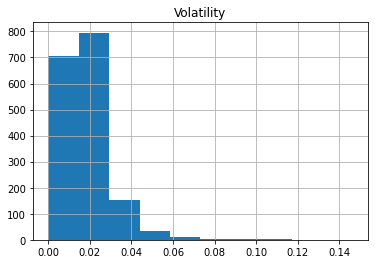

In [199]:
dataset[['Volatility']].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff3cc4fb390>]],
      dtype=object)

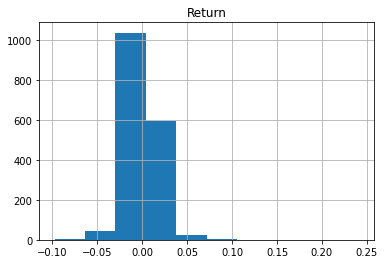

In [200]:
dataset[['Return']].hist()

In [201]:
dataset['Return'].mean()

0.00016623466239642332

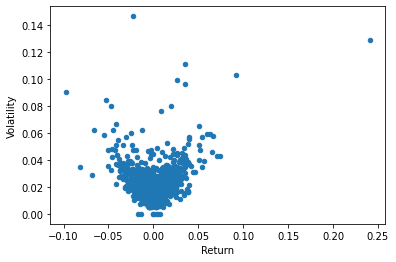

In [202]:
dataset[['Volatility', 'Return']].plot.scatter(x='Return', y='Volatility')

In [203]:
ds1 = dataset.copy()

# dataset has x1,x2,x3,x4,x5,...x100 the daily return one hundred days in the past
for t in range(1,51):
  ds1['Close_%02dDaysAgo'% t] = ds1['Adj Close'].shift(t)
  ds1['Return_%02dDaysAgo'% t] = (ds1['Adj Close'].shift(t) - ds1['Adj Close'])/ds1['Adj Close']
  

# y1,y2,y3,y4,y5. the price five days ahead
for fd in range(1,6):
  ds1['Close_in%01dDay' % fd] = ds1['Adj Close'].shift(-fd)
  ds1['Return_in%01dDay' % fd] = (ds1['Adj Close'].shift(-fd) - ds1['Adj Close'])/ds1['Adj Close']
# Average return over next five days.
avg_return = 0

idx = []
for fe in range(1,6):
  idx += 'Return_in%01dDay' % fd
  
ds1['ForecastAvgReturn5d'] = ds1[['Return_in1Day', 'Return_in2Day','Return_in4Day', 'Return_in4Day','Return_in5Day']].mean(axis=1)
ds1['ForecastMaxReturn5d'] = ds1[['Return_in1Day', 'Return_in2Day','Return_in4Day', 'Return_in4Day','Return_in5Day']].max(axis=1)
ds1['ForecastMinReturn5d'] = ds1[['Return_in1Day', 'Return_in2Day','Return_in4Day', 'Return_in4Day','Return_in5Day']].min(axis=1)

def threeClassOutput(val):
  """Returns -10, 0, 10. A notational value to distinguish classes."""
  if val['ForecastMinReturn5d'] > 0.01:
    return 10
  elif val['ForecastMinReturn5d'] > -0.01:
    return 0
  else:
    return -10 # less than -1%

ds1['3-class'] = ds1.apply(threeClassOutput, axis = 1)


ds1.tail()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using

,High,Low,Open,Close,Volume,Adj Close,Return,Volatility,Close_01DaysAgo,Return_01DaysAgo,...,Close_in3Day,Return_in3Day,Close_in4Day,Return_in4Day,Close_in5Day,Return_in5Day,ForecastAvgReturn5d,ForecastMaxReturn5d,ForecastMinReturn5d,3-class
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-25,180.0,178.5,179.0,179.0,5196700.0,179.0,-0.002793,0.008380,178.5,-0.002793,...,176.0,-0.01676,176.0,-0.01676,NaN,NaN,-0.011872,-0.002793,-0.016760,-10
2020-12-28,180.0,176.5,180.0,177.0,7816100.0,177.0,0.011299,0.019774,179.0,0.011299,...,176.0,-0.00565,NaN,NaN,NaN,NaN,0.001412,0.008475,-0.005650,0
2020-12-29,178.5,177.0,177.0,178.5,5908400.0,178.5,-0.008403,0.008403,177.0,-0.008403,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.014006,-0.014006,-0.014006,-10
2020-12-30,179.0,176.0,179.0,176.0,7337300.0,176.0,0.014205,0.017045,178.5,0.014205,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0
2021-01-04,176.5,174.5,175.0,176.0,7455500.0,176.0,0.000000,0.011364,176.0,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-10


In [204]:
# Remove N/A
ds2 = ds1.dropna()
ds2

,High,Low,Open,Close,Volume,Adj Close,Return,Volatility,Close_01DaysAgo,Return_01DaysAgo,...,Close_in3Day,Return_in3Day,Close_in4Day,Return_in4Day,Close_in5Day,Return_in5Day,ForecastAvgReturn5d,ForecastMaxReturn5d,ForecastMinReturn5d,3-class
Date,,,,,,,,,,,,,,,,,,,,,
2014-03-14,217.0,213.0,215.0,216.0,5378600.0,156.267517,0.004630,0.018519,156.990967,0.004630,...,160.608276,0.027778,162.778671,0.041667,163.502121,0.046296,0.032407,0.046296,0.013889,10
2014-03-17,220.0,215.0,216.0,220.0,5909600.0,159.161362,-0.018182,0.022727,156.267517,-0.018182,...,162.778671,0.022727,163.502121,0.027273,163.502121,0.027273,0.017273,0.027273,-0.004546,0
2014-03-18,222.0,219.0,221.0,219.0,5001600.0,158.437881,0.004566,0.013699,159.161362,0.004566,...,163.502121,0.031964,163.502121,0.031964,162.778671,0.027397,0.026484,0.031964,0.013699,10
2014-03-19,224.0,219.0,219.0,222.0,7495400.0,160.608276,-0.013514,0.022523,158.437881,-0.013514,...,163.502121,0.018018,162.778671,0.013514,164.949036,0.027027,0.017117,0.027027,0.013514,10
2014-03-20,226.0,219.0,220.0,225.0,9110400.0,162.778671,-0.013333,0.031111,160.608276,-0.013333,...,162.778671,0.000000,164.949036,0.013333,164.225601,0.008889,0.008889,0.013333,0.004444,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-18,190.5,187.0,189.5,187.5,12678900.0,187.500000,0.008000,0.018667,189.000000,0.008000,...,177.500000,-0.053333,178.500000,-0.048000,179.000000,-0.045333,-0.048533,-0.045333,-0.053333,-10
2020-12-21,184.5,177.5,182.5,177.5,18273800.0,177.500000,0.056338,0.039437,187.500000,0.056338,...,178.500000,0.005634,179.000000,0.008451,177.000000,-0.002817,0.003944,0.008451,-0.002817,0
2020-12-22,180.0,175.5,178.5,178.5,12598300.0,178.500000,-0.005602,0.025210,177.500000,-0.005602,...,179.000000,0.002801,177.000000,-0.008403,178.500000,0.000000,-0.004482,0.000000,-0.008403,0


In [209]:
idx_label = ['ForecastAvgReturn5d', 'ForecastMaxReturn5d', 'ForecastMinReturn5d']

Y2 = ds2['3-class']

Y = ds2[idx_label]
idx = []
for fe in range(1,51):
  idx.append('Return_%02dDaysAgo' % fd)
X = ds2[idx]
X

,Return_05DaysAgo,Return_05DaysAgo,Return_05DaysAgo,Return_05DaysAgo,Return_05DaysAgo,Return_05DaysAgo,Return_05DaysAgo,Return_05DaysAgo,Return_05DaysAgo,Return_05DaysAgo,...,Return_05DaysAgo,Return_05DaysAgo,Return_05DaysAgo,Return_05DaysAgo,Return_05DaysAgo,Return_05DaysAgo,Return_05DaysAgo,Return_05DaysAgo,Return_05DaysAgo,Return_05DaysAgo
Date,,,,,,,,,,,,,,,,,,,,,
2014-03-14,-0.013889,-0.013889,-0.013889,-0.013889,-0.013889,-0.013889,-0.013889,-0.013889,-0.013889,-0.013889,...,-0.013889,-0.013889,-0.013889,-0.013889,-0.013889,-0.013889,-0.013889,-0.013889,-0.013889,-0.013889
2014-03-17,-0.031818,-0.031818,-0.031818,-0.031818,-0.031818,-0.031818,-0.031818,-0.031818,-0.031818,-0.031818,...,-0.031818,-0.031818,-0.031818,-0.031818,-0.031818,-0.031818,-0.031818,-0.031818,-0.031818,-0.031818
2014-03-18,-0.027397,-0.027397,-0.027397,-0.027397,-0.027397,-0.027397,-0.027397,-0.027397,-0.027397,-0.027397,...,-0.027397,-0.027397,-0.027397,-0.027397,-0.027397,-0.027397,-0.027397,-0.027397,-0.027397,-0.027397
2014-03-19,-0.054054,-0.054054,-0.054054,-0.054054,-0.054054,-0.054054,-0.054054,-0.054054,-0.054054,-0.054054,...,-0.054054,-0.054054,-0.054054,-0.054054,-0.054054,-0.054054,-0.054054,-0.054054,-0.054054,-0.054054
2014-03-20,-0.035556,-0.035556,-0.035556,-0.035556,-0.035556,-0.035556,-0.035556,-0.035556,-0.035556,-0.035556,...,-0.035556,-0.035556,-0.035556,-0.035556,-0.035556,-0.035556,-0.035556,-0.035556,-0.035556,-0.035556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-18,0.008000,0.008000,0.008000,0.008000,0.008000,0.008000,0.008000,0.008000,0.008000,0.008000,...,0.008000,0.008000,0.008000,0.008000,0.008000,0.008000,0.008000,0.008000,0.008000,0.008000
2020-12-21,0.076056,0.076056,0.076056,0.076056,0.076056,0.076056,0.076056,0.076056,0.076056,0.076056,...,0.076056,0.076056,0.076056,0.076056,0.076056,0.076056,0.076056,0.076056,0.076056,0.076056
2020-12-22,0.050420,0.050420,0.050420,0.050420,0.050420,0.050420,0.050420,0.050420,0.050420,0.050420,...,0.050420,0.050420,0.050420,0.050420,0.050420,0.050420,0.050420,0.050420,0.050420,0.050420


In [210]:
Y.tail()

,ForecastAvgReturn5d,ForecastMaxReturn5d,ForecastMinReturn5d
Date,,,
2020-12-18,-0.048533,-0.045333,-0.053333
2020-12-21,0.003944,0.008451,-0.002817
2020-12-22,-0.004482,0.000000,-0.008403
2020-12-23,0.003380,0.008451,-0.008451
2020-12-24,-0.009524,0.002801,-0.014006


In [211]:
# Split train-test

train_dataset = ds2.sample(frac=0.8, random_state=0)
Y_train = train_dataset[idx_label]
idx = []
for fe in range(1,51):
  idx.append('Return_%02dDaysAgo' % fe)
X_train = train_dataset[idx]


test_dataset = ds2.sample(frac=0.8, random_state=0)
Y_test = train_dataset[idx_label]
X_test = train_dataset[idx]

In [212]:
X.values.shape

(1653, 50)

In [213]:
Y.values.shape

(1653, 3)

In [214]:
import statsmodels.api as sm
model = sm.OLS(Y.values,X.values)
results = model.fit()
results.params

array([[0.00126634, 0.00187802, 0.0001893 ],
       [0.00126634, 0.00187802, 0.0001893 ],
       [0.00126634, 0.00187802, 0.0001893 ],
       [0.00126634, 0.00187802, 0.0001893 ],
       [0.00126634, 0.00187802, 0.0001893 ],
       [0.00126634, 0.00187802, 0.0001893 ],
       [0.00126634, 0.00187802, 0.0001893 ],
       [0.00126634, 0.00187802, 0.0001893 ],
       [0.00126634, 0.00187802, 0.0001893 ],
       [0.00126634, 0.00187802, 0.0001893 ],
       [0.00126634, 0.00187802, 0.0001893 ],
       [0.00126634, 0.00187802, 0.0001893 ],
       [0.00126634, 0.00187802, 0.0001893 ],
       [0.00126634, 0.00187802, 0.0001893 ],
       [0.00126634, 0.00187802, 0.0001893 ],
       [0.00126634, 0.00187802, 0.0001893 ],
       [0.00126634, 0.00187802, 0.0001893 ],
       [0.00126634, 0.00187802, 0.0001893 ],
       [0.00126634, 0.00187802, 0.0001893 ],
       [0.00126634, 0.00187802, 0.0001893 ],
       [0.00126634, 0.00187802, 0.0001893 ],
       [0.00126634, 0.00187802, 0.0001893 ],
       [0.

class Adadelta: Optimizer that implements the Adadelta algorithm.
class Adagrad: Optimizer that implements the Adagrad algorithm.
class Adam: Optimizer that implements the Adam algorithm.
class Adamax: Optimizer that implements the Adamax algorithm.
class Ftrl: Optimizer that implements the FTRL algorithm.
class Nadam: Optimizer that implements the Nadam algorithm.
class Optimizer: Abstract optimizer base class.
class RMSprop: Optimizer that implements the RMSprop algorithm.
class SGD: Gradient descent (with momentum) optimizer.

https://www.tensorflow.org/api_docs/python/tf/keras/optimizers



https://www.tensorflow.org/tutorials/keras/regression

In [215]:
from keras.models import Sequential 
from keras.layers import Activation, Dense, Normalization
import tensorflow as tf


returns_normalizer = Normalization(input_shape=[50,], axis=None)
returns_normalizer.adapt(X_train)

model = Sequential() 
layer_1 = Dense(50, input_shape = (50,))   # Input
layer_2 = Dense(32, activation="sigmoid") 
layer_3 = Dense(8, activation="sigmoid") 
# layer_4 = Dense(1, activation='sigmoid')  # Output
layer_4 = Dense(3, activation='sigmoid')  # Output

model.add(returns_normalizer)
model.add(layer_1) 
model.add(layer_2) 
model.add(layer_3) 
model.add(layer_4) 

# Mean squared error (MSE) (tf.keras.losses.MeanSquaredError)
# model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

# model.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(0.1))
# model.compile(loss='mae', optimizer=tf.keras.optimizers.SGD())


# model.compile(loss='mse', optimizer=tf.keras.optimizers.SGD())

model.compile(loss='mse', optimizer=tf.keras.optimizers.SGD())


50-128-64-1.  looks overfit
50-32-8-1  

50-4-4-1  
loss: 5.4349e-04 - val_loss: 5.9303e-04


50-64-1  

50-4-1  

SGD optimizer makes more sense than Adam optimizer


In [186]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_4 (Normalizat  (None, 50)               3         
 ion)                                                            
                                                                 
 dense_43 (Dense)            (None, 50)                2550      
                                                                 
 dense_44 (Dense)            (None, 32)                1632      
                                                                 
 dense_45 (Dense)            (None, 8)                 264       
                                                                 
 dense_46 (Dense)            (None, 3)                 27        
                                                                 
Total params: 4,476
Trainable params: 4,473
Non-trainable params: 3
___________________________________________________

Train.

In [192]:

history = model.fit(X_train.values, Y_train.values,
    validation_split=0.6, epochs=20, batch_size=1)


Epoch 1/20
528/528 [==============================] - 1s 3ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 2/20
528/528 [==============================] - 1s 3ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 3/20
528/528 [==============================] - 1s 3ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 4/20
528/528 [==============================] - 1s 3ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 5/20
528/528 [==============================] - 1s 3ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 6/20
528/528 [==============================] - 2s 4ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 7/20
528/528 [==============================] - 1s 3ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 8/20
528/528 [==============================] - 1s 3ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 9/20
528/528 [==============================] - 1s 3ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 10/20
528/528 [==============================] - 1s 3ms/step - loss: 0.0011 - val_loss: 0.0010

In [188]:
history.epoch

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [189]:
accuracy = model.evaluate(X_train.values, Y_train.values)
print('Accuracy: %.2f' % (accuracy*100))

42/42 [==============================] - 0s 3ms/step - loss: 0.0013
Accuracy: 0.13


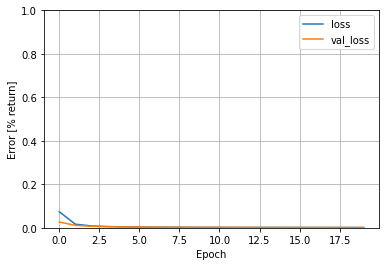

In [190]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 1])
  plt.xlabel('Epoch')
  plt.ylabel('Error [% return]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

In [178]:
X_test[45:46]

,Return_01DaysAgo,Return_02DaysAgo,Return_03DaysAgo,Return_04DaysAgo,Return_05DaysAgo,Return_06DaysAgo,Return_07DaysAgo,Return_08DaysAgo,Return_09DaysAgo,Return_10DaysAgo,...,Return_41DaysAgo,Return_42DaysAgo,Return_43DaysAgo,Return_44DaysAgo,Return_45DaysAgo,Return_46DaysAgo,Return_47DaysAgo,Return_48DaysAgo,Return_49DaysAgo,Return_50DaysAgo
Date,,,,,,,,,,,,,,,,,,,,,
2017-04-27,0.002857,0.002857,-0.002857,-0.005714,-0.008572,-0.017143,-0.008572,0.0,0.005714,-0.005714,...,-0.049735,-0.058096,-0.055309,-0.063669,-0.052522,-0.044162,-0.055309,-0.058096,-0.055309,-0.058096


In [179]:
sample1 = X_test[45:46].values
model.predict(sample1)

1/1 [==============================] - 0s 66ms/step


array([[0.01685221, 0.021603  , 0.01235174]], dtype=float32)

In [180]:

Y_test[45:46]

,ForecastAvgReturn5d,ForecastMaxReturn5d,ForecastMinReturn5d
Date,,,
2017-04-27,0.010857,0.022857,0.0


In [223]:
result = []

for ix in X_test.index:
  actual = Y_test.loc[ix]
  x = X_test.loc[ix].values.reshape(1,50)
  pred = model(x)
  pred = pred.numpy()
  print("Actual: %s Predict: %s" % (actual, pred))

  result.append({'actual': actual[0], 'predict': pred[0][0]})
result = pd.DataFrame(result)


Streaming output truncated to the last 5000 lines.
Actual: ForecastAvgReturn5d   -0.015686
ForecastMaxReturn5d    0.002801
ForecastMinReturn5d   -0.030812
Name: 2018-11-30, dtype: float64 Predict: [[0.7484116 0.5345086 0.7418144]]
Actual: ForecastAvgReturn5d    0.043103
ForecastMaxReturn5d    0.068965
ForecastMinReturn5d    0.008621
Name: 2016-08-02, dtype: float64 Predict: [[0.7280568 0.5302648 0.7165011]]
Actual: ForecastAvgReturn5d   -0.006494
ForecastMaxReturn5d   -0.003247
ForecastMinReturn5d   -0.009740
Name: 2016-11-02, dtype: float64 Predict: [[0.74559987 0.52901226 0.743053  ]]
Actual: ForecastAvgReturn5d    0.003681
ForecastMaxReturn5d    0.012270
ForecastMinReturn5d   -0.006135
Name: 2016-06-02, dtype: float64 Predict: [[0.74661744 0.54101616 0.726553  ]]
Actual: ForecastAvgReturn5d   -0.019108
ForecastMaxReturn5d   -0.009554
ForecastMinReturn5d   -0.035032
Name: 2016-04-08, dtype: float64 Predict: [[0.73470753 0.5211574  0.73157084]]
Actual: ForecastAvgReturn5d   -0.011549


In [224]:
X_test.loc['2018-04-26'].values.shape

(50,)

In [225]:
sample0 = X_test.loc['2018-04-26'].values.reshape(1,50)

pred = model(sample0)
pred.numpy()[0,0]

0.72546697

In [226]:
# sample0 = X_test.loc['2018-04-26']
# sample0

In [227]:
result

,actual,predict
0,0.006796,0.725467
1,-0.006897,0.729443
2,0.057534,0.744059
3,-0.005042,0.735269
4,-0.038418,0.750337
...,...,...
1317,0.000930,0.721648
1318,-0.007512,0.723175
1319,0.020482,0.744493
1320,0.003955,0.738188


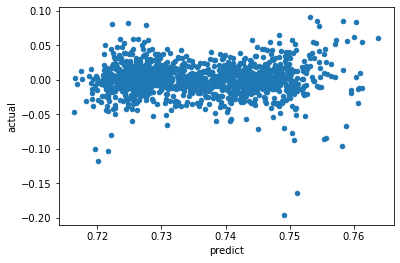

In [228]:
result.plot.scatter(x='predict',y='actual', title="Predict vs Actual")